# Classification via KNN & SVM

__Team Members:__ Surya Suresh Sriraman, Nivetha Sivakumar, Aravind Raju

# Introduction

This work will explore a dataset The data set is comprised of more than 14,000 observations of 1 response/dependent variable (which indicates whether or not the new insurance product was purchased) and 14 explanatory/independent
variables. The primary objective of the project is to construct and compare/contrast a series of binary logistic regression models that predict whether or not a given insurance company customer is likely to purchase an additional insurance product. 

__Approach:__<br>
- __Develop Domain Knowledge:__ Gain an understanding of the domain the data belongs to.
- __Data Loading:__ Utilize Python and the Pandas library to load the data into a suitable DataFrame.
- __Exploratory Data Analysis (EDA):__  Explore and analyze the dataset to identify patterns, trends, and relationships. This step involves data visualization, summary statistics, and initial insights to inform subsequent analyses.
- __Data Preparation:__ Clean and pre process the data to handle missing values, outliers, and ensure it is in a suitable format for analysis. This step may involve feature engineering and encoding categorical variables.
- __Prep Data Review:__ Review the prepared dataset to ensure that transformations and preprocessing steps have been applied correctly. Confirm that the data is ready for modeling.
- __Modelling:__ The dataset is split into training and testing subsets, and build different models.
- __Select Best Performing Model:__ Evaluate and compare the performance of different distance based models using appropriate metrics. Select the model that best fits the data and provides the most accurate predictions.



Note: Some data preparation steps are performed along with EDA to improve process efficiency

# Import Libraries

In [ ]:
# Import required libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from sklearn.impute import KNNImputer
from scipy.stats import boxcox
from scipy.stats.mstats import winsorize
from sklearn.feature_selection import VarianceThreshold
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_regression
from sklearn.feature_selection import SelectPercentile
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score,roc_auc_score, roc_curve, auc, classification_report, confusion_matrix
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
import statsmodels.api as sm
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN
from collections import Counter
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RepeatedStratifiedKFold,GridSearchCV

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

# Data Loading

In [ ]:
# Based on Domain knowledge assign proper data types to the columns while loading the data
column_types = {        
        'TARGET': object,    
        'loyalty': object,
        'ID': 'int64',
        'age': 'int64',
        'city': object,
        'LOR': 'int64',    
        'prod_A': object,
        'type_A': object,
        'type_B': object,
        'prod_B': object,    
        'turnover_A': float,
        'turnover_B': float,
        'contract': object,
        'age_P': 'int64',
        'lor_M': 'int64'  
    }

# Load data into Pandas DataFrame
cust_df = pd.read_csv(r"https://raw.githubusercontent.com/s-surya-s/DAV-6150/main/M7_Data.csv", sep = ",", engine = 'python', dtype=column_types)

# Drop unique identifier columns as they don't add any predictive value
cust_df = cust_df.drop(columns=['ID'], axis =1)

# Reorder the DataFrame columns
cust_df = cust_df[['TARGET', 'loyalty', 'city', 'prod_A', 'type_A', 'type_B', 'prod_B', 'contract','age', 'age_P', 'lor_M', 'LOR', 'turnover_A', 'turnover_B']]

# sanity check - make sure data was read in as expected
cust_df.head()

# Exploratory Data Analysis

In [ ]:
cust_df.info()

## Summary Statistics

In [ ]:
cust_num = cust_df.select_dtypes(include=['int', 'float'])

cust_cat = cust_df.select_dtypes(include=[object])

print("Numeric Columns:")
display(cust_num.describe())

print("Categorical Columns:")
display(cust_cat.describe())

In [ ]:
# Check Duplicates
'Duplicates Found' if cust_df.duplicated().any() else 'No Duplicates'

Let's drop the duplicates

In [ ]:
len_before = len(cust_df)
cust_df = cust_df.drop_duplicates()

print(f'Number of duplicates found: {len_before - len(cust_df)}')

In [ ]:
#Check Nulls
'Nulls Found' if cust_df.isnull().sum().sum() != 0 else 'No Nulls'

## Univariate Analysis

In [ ]:
# Function for Univariate Analysis

def Univariate_EDA(df, col):
    '''
    Performs Univariate Analysis

    Args:
    - df: Dataframe for Univariate analysis
    - col: Column in the df for Univariate analysis

    Returns:
    None
    '''
    
    print('\n','-'*20, col,'-'*20)

    # Temporarily remove null values to view the distribution
    df = df[df[col].notnull()]
    
    # get summary statistics
    print('Summary Statistics')
    display(df[col].describe())
    
    if df[col].dtype == 'object':
        # Display unique values
        if len(df[col].unique())<=10:
            print('Unique Values')
            display(df[col].unique())
        else:
            print('Note: The graph displays only the top 20 frequent values')

        # Create a bar plot of the value counts
        plt.figure(figsize=(6, 5))
        plt.title(col)

        # Get value counts for the variable
        frequency = df[col].value_counts().head(20)
        sns.barplot(x=frequency.index, y=frequency.values, palette="viridis")
        plt.title(col)
        plt.ylabel("Counts")
        plt.tick_params(axis='x', rotation=90)

        # Display plot
        plt.tight_layout()
        plt.show()
        
        print("Insights:")
        if len(df[col].unique()) == 1:
            print(f"The {col} has only one unique value, {df[col].unique()[0]}")
        else:
            print("The {} column is comprised of {} distinct categorical values, with the most frequently occurring value being '{}'".format(col, len(df[col].unique()),df[col].mode()[0]))
    
    if df[col].dtype == 'float64' or df[col].dtype == 'int64':

        plt.figure(figsize=(6, 3))
        plt.suptitle(col)

        # Plot histogram
        plt.subplot(1, 2, 1)
        #sns.histplot(data=df, x=col, kde=True, color='skyblue')
        df[col].hist()

        # Plot boxplot
        plt.subplot(1, 2, 2)
        sns.boxplot(data=df, x=col, color='green')

        # Display plot
        plt.tight_layout()
        plt.show()

        print("Insights:")
        # Check skewness and distribution
        if df[col].median() == df[col].mean():
            skewtext = 'the median equals the mean. Plot shows normal distribution.'
        elif df[col].median() > df[col].mean():
            skewtext = 'median exceeds mean. Plot shows left skewness.'
        else:
            skewtext = 'mean exceeds median. Plot shows right skewness.'

        print(f'Summary statistics, histogram, and boxplot indicate {skewtext}\nThe values range between {df[col].min()} and {df[col].max()}.')

        # Outliers detection
        q1 = np.quantile(df[col], 0.25)
        q3 = np.quantile(df[col], 0.75)
        iqr = q3 - q1
        upper_bound = q3 + (1.5 * iqr)
        lower_bound = q1 - (1.5 * iqr)
        outlier = (df[col] < lower_bound) | (df[col] > upper_bound)

        # Display outliers information
        if outlier.sum() > 0:
            print('Outliers Detected!')
            print('Outliers%: {}'.format(round(100 * outlier.mean(), 2)))

    return None

In [ ]:
for col in cust_df.columns:    
    Univariate_EDA(cust_df, col)

## Bivariate Analysis

### Numeric vs Numeric Columns

In [ ]:
# Calculate the correlation matrix
correlation_matrix = cust_df.corr()

# Create a heatmap using seaborn
plt.figure(figsize=(6,4))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Plot')
plt.show()

__Insights__ : The heatmap shows the high correlation between the following variables:
1) age_p and age
2) lor_M and LOR

### Target vs Numeric Columns

In [ ]:
pos = 1
target = 'TARGET'
plt.figure(figsize=(20, 4))
plt.suptitle('Target vs Numeric Columns')

for col in cust_num.columns:  

    plt.subplot(1,6,pos)
    sns.boxplot(x=target, y=col, data=cust_df)
    plt.title(target+' vs '+col)
    plt.xticks(rotation=90)
    
    pos += 1
    
plt.tight_layout()   
plt.show()

__Insights__ : The box plot reveals the following insights:
1) Target vs age : People who are more likely to purchase a new product are mostly between the age range of 30 to 50.
2) Target vs age_p : People who are more likely to purchase a new product are mostly between the age range of 30 to 50.
3) Target vs lor_M : People who are more likely to purchase a new product are mostly between the range of 2 to 15 months of relationship with the company.
4) Target vs LOR : People who are more likely to purchase a new product are mostly between the range of 2 to 15 months of relationship with the company.
5) Target vs turnover_A : The turnover of product A has no specific pattern to link directly with target variable.
6) Target vs turnover_B : The turnover of product B has no specific pattern to link directly with target variable.

### Target vs Categorical Columns

In [ ]:
pos = 1
target = 'TARGET'
plt.figure(figsize=(16, 8))
plt.suptitle('Target vs Categorical Columns')

for col in cust_cat.columns[1:]:  

    plt.subplot(2,4,pos)
    sns.countplot(x=col, hue=target, data=cust_df)
    plt.title(target+' vs '+col)
    plt.xticks(rotation=90)
    
    if pos%4 !=1:
        plt.legend().set_visible(False) 
    
    pos += 1
    
plt.tight_layout()   
plt.show()

__Insights__ : The bar plot reveals the following insights:
1) Target vs loyalty : Unlikely People with loyalty of 3 are more likely to not purchase a new product.
2) Target vs city : There is no specific relationship between the city and target variable.
3) Target vs prod_A : People who purchase product A are more likely to not purchase a new product.
4) Target vs type_A : People who purchase product A of type 3 are more likely to not purchase a new product.
5) Target vs type_B : People who purchase product B of type 3 are more likely to not purchase a new product.
6) Target vs prod_B : People who purchase product B are more likely to not purchase a new product.

# Data Preparation

## Feature Selection

From EDA we found the following

- The contract column has only one value. We can drop the column as it does not have any variance.
- The city column 97.8% values as '2'. We can drop the column as it has very low variance.
- The following columns are 100% correlated. We can retain any one highly correalted column to prevent multicollinearity.
    - age, age_P
    - lor_M, LOR

In [ ]:
cust_df = cust_df.drop(columns=['contract', 'city', 'age_P', 'lor_M'], axis =1)

# Sanity Check
cust_df.columns

## Handling Outliers

In [ ]:
# Define column names and their corresponding winsorization limits
# The limits are derived from EDA insights
col_limits = {'age' : 0.022,
           'turnover_A' : 0.0364,
           'turnover_B' : 0.091}

# Iterate through the columns and apply winsorization
for col in col_limits.keys():   
    cust_df[col] = winsorize(cust_df[col], limits=[None, col_limits[col]])
    
# Sanity Check - Outliers      
pos = 1
plt.figure(figsize=(12, 4))
plt.title('Sanity Check - Outliers')

for col in col_limits.keys():  

    plt.subplot(1,3,pos)
    sns.boxplot(data=cust_df, y=col, color='green')
    pos += 1
    
plt.tight_layout()   
plt.show()

## Grouping Sparse Columns

Let's create bins to categorize the customers as existing or new based on their length of relationship. The LOR column is mostly filled with 0 and 1 compared to other values.

In [ ]:
# Label customers with LOR less than 1 year as 'New' and remaining as 'Existing'
cust_df['LOR'] = cust_df['LOR'].apply(lambda x: 'New' if x < 1 else 'Existing')

# Sanity Check
cust_df['LOR'].unique()

## Feature Engineering

In [ ]:
# List of columns to one-hot encode
encode_cols = cust_df.select_dtypes(include=[object]).columns

# Apply one-hot encoding to the specified columns
encoded_df = pd.get_dummies(cust_df[encode_cols], drop_first=True)

# Drop the original columns from the DataFrame
cust_df.drop(columns=encode_cols, inplace=True)

# Concatenate the original DataFrame with the one-hot encoded columns
cust_df = pd.concat([cust_df, encoded_df], axis=1)

cust_df.rename(columns = {'TARGET_Y':'TARGET'}, inplace =True)

cust_df.head()

## Split the Data

In [ ]:
# Explanatory Variable
X = cust_df.copy().drop('TARGET', axis=1)
X.head(2)

In [ ]:
# Response Variable
y = cust_df['TARGET']
y.unique()

## SMOTE + ENN

SMOTE + ENN is an hybrid technique. SMOTE oversamples the minority class by creating synthetic data points. ENN undersamples both the majority and minority classes by identifying and removing noisy or irrelevant data points Integrating these techniques results in a more clear and concise class separation.

Ref: https://www.analyticsvidhya.com/blog/2020/10/overcoming-class-imbalance-using-smote-techniques/ 

In [ ]:
counter = Counter(y)
print(f'Before {Counter(y)}')

smenn = SMOTEENN()
X, y = smenn.fit_resample(X,y)

print(f'After {Counter(y)}')

## Feature Selection

### Variance Thresholding

In [ ]:
# Create the VarianceThreshold object (remove features with variance below the threshold)
selector = VarianceThreshold(threshold=0.01)

# Fit the selector to the data
selector.fit(X)

selector.get_support()

#get the list of eaturs with low variance
lowvar_col = [column for column in X.columns if column not in X.columns[selector.get_support()]]

print(f"Features with Low Variance:{lowvar_col}")

#drop low variance columns
X = X.drop(lowvar_col,axis=1)

print(f"Shape of dataframe after removing the low variance columns:{X.shape}")

### Mutual Information

In [ ]:
mic = mutual_info_regression(X, y)

mic_df = pd.DataFrame({"feature": X.columns, "vimp": mic}).sort_values(by="vimp", ascending=False)

plt.figure(figsize=(10, 5))
sns.barplot(data = mic_df, x='feature', y='vimp', color='red')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [ ]:
selected_top_columns =  SelectPercentile(mutual_info_regression, percentile=50)

selected_top_columns.fit(X, y)

X = X[X.columns[selected_top_columns.get_support()]].reset_index(drop = True)

X.head()

## Scaling Numeric features

In [ ]:
columns_to_scale = ['age','turnover_A', 'turnover_B']

scaler = StandardScaler()

# Fit and transform the selected columns
scaled_columns = scaler.fit_transform(X[columns_to_scale])

# Create a DataFrame with scaled columns
scaled_df = pd.DataFrame(scaled_columns, columns=columns_to_scale)

# Replace the scaled columns in the original DataFrame
X[columns_to_scale] = scaled_df

X.head()

# Prepped Data Review

In [ ]:
# Create a dataframe with prepped data to perform EDA
prep_eda_df = pd.concat([X, y], axis=1)
prep_eda_df.head(2)

In [ ]:
prep_eda_df.describe()

In [ ]:
plt.figure(figsize=(6, 6))

pos = 1
for col in ['age', 'turnover_A', 'turnover_B']:

    plt.subplot(3,2,pos)
    sns.histplot(data=prep_eda_df, x=col)    
    pos+=1
    
    plt.subplot(3,2,pos)
    sns.boxplot(data=prep_eda_df, x=col)
    pos+=1
        
plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=(3, 3))
frequency = prep_eda_df['TARGET'].value_counts()
sns.barplot(x=frequency.index, y=frequency.values, palette="viridis")
plt.title('TARGET')
plt.ylabel("Frequency")

In [ ]:
pos = 1
target = 'TARGET'
plt.figure(figsize=(10, 3))

for col in prep_eda_df.columns.difference(['age', 'turnover_A', 'turnover_B', 'TARGET']):  

    plt.subplot(1,3,pos)
    sns.countplot(x=col, hue=target, data=prep_eda_df)
    plt.title(target+' vs '+col)
    plt.xticks(rotation=90)
    
    pos += 1
    
plt.tight_layout()   
plt.show()

# KNN + SVM Modelling

## Train Test Split

In [ ]:
# Perform the train-test split (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Reset the index for the training set
X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)

# Reset the index for the testing set
X_test = X_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

# Print the shapes of the resulting sets
print("Training set shapes - X: {}, y: {}".format(X_train.shape, y_train.shape))
print("Testing set shapes - X: {}, y: {}".format(X_test.shape, y_test.shape))

## KNN

### Selecting the K-value

In [ ]:
# Define range of neighbors (K) for cross-validation
neighbors = range(1, 50)

# Perform cross-validation for each value of K
cv_scores = []
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_train, y_train, cv=5, scoring='accuracy')  # 5-fold cross-validation
    cv_scores.append(scores.mean())

# Plot cross-validation curve
plt.figure()
plt.plot(neighbors, cv_scores, marker='o')
plt.xlabel('Number of Neighbors (K)')
plt.ylabel('Cross-Validation Accuracy')
plt.title('Cross-Validation Curve for KNN')
plt.grid(True)
plt.show()

Let's select K-value as 3 as it has high accuracy and has reduced chance of overfitting compared to smaller k-values.

### Building the Model

In [ ]:
def knn_model(X_train, y_train, X_test, y_test, features):
    """
    Train a k-Nearest Neighbors (KNN) model, make predictions, and evaluate its performance.

    Parameters:
    - X_train: Training features
    - y_train: Training labels
    - X_test: Testing features
    - y_test: Testing labels
    - features: List of feature names to use in training the model

    Returns:
    - Accuracy score on the test set
    """

    # Create a KNN model
    knn = KNeighborsClassifier(n_neighbors=3)

    # Train the KNN model using the specified features
    knn.fit(X_train[features], y_train)   

    y_pred = knn.predict(X_test[features])
        
    print("Confusion Matrix:")
    print(confusion_matrix(y_test,y_pred))

    print("\nClassification Report:")
    print(classification_report(y_test,y_pred))
    
    return {'Accuracy': round(accuracy_score(y_test, y_pred),2),
            'Precision': round(precision_score(y_test, y_pred),2),
            'Recall': round(recall_score(y_test, y_pred),2),
            'F1-Score': round(f1_score(y_test, y_pred),2)}   

### KNN Model 1

Build a SVM model with all features

In [ ]:
knn_model1 = knn_model(X_train, y_train, X_test, y_test, X_train.columns)

print(knn_model1)

### KNN Model 2

Build a KNN model with selected 3 features

In [ ]:
knn_model2 = knn_model(X_train, y_train, X_test, y_test, ['age', 'turnover_A', 'turnover_B'])

print(knn_model2)

### KNN Model 3

Build a KNN model with selected 2 features

In [ ]:
knn_model3 = knn_model(X_train, y_train, X_test, y_test, ['turnover_A', 'turnover_B'])

print(knn_model3)

## SVM

In [ ]:
def svm_model(X_train, y_train, X_test, y_test, features):
    """
    Train an SVM model and evaluate its accuracy.

    Parameters:
    - X_train: Training features
    - y_train: Training labels
    - X_test: Testing features
    - y_test: Testing labels
    - features: List of feature names to use in training the model

    Returns:
    - Accuracy score on the test set
    """

    # Create an SVM model with probability estimates enabled
    svc = SVC(random_state=42, probability=True)

    # Train the SVM model using the specified features
    svc.fit(X_train[features], y_train)
        
    # y_pred = svc.predict(X_test[features])
    y_pred = svc.predict(X_test[features])
    
    print("Confusion Matrix:")
    print(confusion_matrix(y_test,y_pred))

    print("\nClassification Report:")
    print(classification_report(y_test,y_pred))
    
    # Evaluate the model on the test set and calculate accuracy
    
    return {'Accuracy': round(accuracy_score(y_test, y_pred),2),
            'Precision': round(precision_score(y_test, y_pred),2),
            'Recall': round(recall_score(y_test, y_pred),2),
            'F1-Score': round(f1_score(y_test, y_pred),2)}   

### SVM Model 1

Build a SVM model with all features

In [ ]:
svm_model1 = svm_model(X_train, y_train, X_test, y_test, X_train.columns)

print(svm_model1)

### SVM Model 2

Build a SVM model with selected 3 features

In [ ]:
svm_model2 = svm_model(X_train, y_train, X_test, y_test, ['age', 'turnover_A', 'turnover_B'])

print(svm_model2)

### SVM Model 3

Build a SVM model with selected 2 features

In [ ]:
svm_model3 = svm_model(X_train, y_train, X_test, y_test, ['turnover_A', 'turnover_B'])

print(svm_model3)

# Select Models

In [ ]:
model_eval = pd.DataFrame()

model_eval = model_eval.append(pd.Series(knn_model1, name='KNN Model 1'))
model_eval = model_eval.append(pd.Series(knn_model2, name='KNN Model 2'))
model_eval = model_eval.append(pd.Series(knn_model3, name='KNN Model 3'))

model_eval = model_eval.append(pd.Series(svm_model1, name='SVM Model 1'))
model_eval = model_eval.append(pd.Series(svm_model2, name='SVM Model 2'))
model_eval = model_eval.append(pd.Series(svm_model3, name='SVM Model 3'))

model_eval

In [ ]:
print(f'Null Error Rate: {round(y_train.value_counts(normalize=True).max(),2)}')

All the models are performing well when compared to the null error rate.

 Considering all the metrics __KNN model 2__ with ['age', 'turnover_A', 'turnover_B'] features is performing well and it is the best choice.

## Comparison with logistic regression model from M7

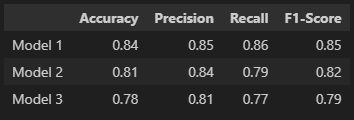

The best performing logistic regression model was __Model 1__. 

On comparison, even the low performing KNN and SVM models outperforms the best performing logistic regression model across all metrics. This highlights the robustness of the distance-based models.

# Conclusion

The exploratory data analysis (EDA) played a pivotal role in identifying outliers and correlated features. Leveraging these insights, we strategically removed insignificant columns. Subsequently, employing the winsorize method, we rectified outliers and aggregated sparse categories. 

In feature engineering, we encoded categorical columns into dummy variables. We used SMOTE ENN to handle class imbalance within the target column. Thereafter, utilizing variance threshold and mutual information, we conducted feature selection. Following this, a post-EDA was performed on the prepared dataset.

Finally, we built 3 different KNN and SVM models with different sets of features. 

Throughout the process, we curated the dataset, addressing outliers, categorical encoding, and class imbalances. Leveraging advanced techniques like SMOTE ENN and feature selection, we optimized model performance, ultimately recognizing our KNN model 2's dominance in predictive accuracy and stability.